In [19]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose
from keras.constraints import max_norm
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Lambda,Subtract
from keras.callbacks import EarlyStopping
import keras.backend as K
import keras.layers as KL
import keras.engine as KE
import keras.models as KM
import math
from skimage.measure import compare_psnr,compare_mse

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [4]:
# Model configuration
img_width, img_height = 32, 32
batch_size = 32
no_epochs = 50
validation_split = 0.04
verbosity = 1
max_norm_value = 2.0
noise_factor = 0.25
number_of_visualizations = 10

In [5]:

x_train = x_train.reshape(x_train.shape[0],  img_width, img_height,3)
x_test = x_test.reshape(x_test.shape[0], img_width, img_height,3)


  

In [6]:
# x_shape = (3 ,img_width, img_height)

In [7]:
# Parse numbers as floats
input_train = x_train.astype('float32')
input_test = x_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255


In [8]:
x_train_line = np.copy(input_train)
x_test_line = np.copy(input_test)

In [9]:
# Add noise
def drawLines(x):
    for i in range(len(x)):
        numLines = np.random.randint(20) + 1
        for l in range(numLines):
            if l % 2 == 0:
                vh = np.random.randint(2)
                start = np.random.randint(10)
                length = start + np.random.randint(4,21)
                position = np.random.randint(32)
                for j in range(3):
                    if vh == 0:
                        x[i,:,:,j][start:length, position] = 0
                    else:
                        x[i,:,:,j][position, start:length] = 0
            else:
                vh = np.random.randint(2)
                start = np.random.randint(10,25)
                length = start + np.random.randint(5,32-start)
                position = np.random.randint(32)
                for j in range(3):
                    if vh == 0:
                        x[i,:,:,j][start:length, position] = 0
                    else:
                        x[i,:,:,j][position, start:length] = 0
    return x

In [10]:
x_train_line = drawLines(x_train_line)
x_test_line = drawLines(x_test_line)

In [11]:
from keras.models import load_model
from keras.models import *

In [15]:
def unet():
        "unet for image reconstruction"
        P0 = x = KL.Input(shape=(None,None,3),name="u_net_input")
        x = KL.Conv2D(64, (3, 3), strides=(1, 1), name='conv1', use_bias=True,padding="same")(x)
        x = KL.Lambda(lambda t:keras.activations.relu(t,alpha=0.1))(x)
        x = KL.Conv2D(64, (3, 3), strides=(2, 2), name='conv1a', use_bias=True,padding="same")(x)
        P1= x = KL.Lambda(lambda t:keras.activations.relu(t,alpha=0.1))(x)

        x = KL.Conv2D(64,(3,3),strides=(1,1),name='conv2',use_bias=True,padding="same")(x)
        x = KL.Lambda(lambda t:keras.activations.relu(t,alpha=0.1))(x)
        x = KL.Conv2D(64,(3,3),strides=(2,2),name='conv2a',use_bias=True,padding="same")(x)
        P2= x = KL.Lambda(lambda t:keras.activations.relu(t,alpha=0.1))(x)
        
        x = KL.Conv2D(128,(3,3),strides=(1,1),name='conv3',use_bias=True,padding="same")(x)
        x = KL.Lambda(lambda t:keras.activations.relu(t,alpha=0.1))(x)
        x = KL.Conv2D(128,(3,3),strides=(2,2),name='conv3a',use_bias=True,padding="same")(x)
        P3= x = KL.Lambda(lambda t:keras.activations.relu(t,alpha=0.1))(x)

        x = KL.Conv2D(128,(3,3),strides=(1,1),name='conv4',use_bias=True,padding="same")(x)
        x = KL.Lambda(lambda t:keras.activations.relu(t,alpha=0.1))(x)
        x = KL.Conv2D(128,(3,3),strides=(2,2),name='conv4a',use_bias=True,padding="same")(x)
        P4= x = KL.Lambda(lambda t:keras.activations.relu(t,alpha=0.1))(x)

        x = KL.Conv2D(256,(3,3),strides=(1,1),name='conv5',use_bias=True,padding="same")(x)
        x = KL.Lambda(lambda t:keras.activations.relu(t,alpha=0.1))(x)
        x = KL.Conv2D(256,(3,3),strides=(2,2),name='conv5a',use_bias=True,padding="same")(x)
        P5= x = KL.Lambda(lambda t:keras.activations.relu(t,alpha=0.1))(x)

        x = KL.Deconvolution2D(nb_filter=128, nb_row=3, nb_col=3,subsample=(1, 1),name='deconv4',border_mode='same')(x)
        x = KL.Lambda(lambda t:keras.activations.relu(t,alpha=0.1))(x)
        x = KL.Deconvolution2D(nb_filter=128, nb_row=3, nb_col=3,subsample=(2, 2),name='deconv4a',border_mode='same')(x)
        x = KL.Lambda(lambda t:keras.activations.relu(t,alpha=0.1))(x)
        C4= x = KL.Add()([P4,x])

        x = KL.Deconvolution2D(nb_filter=128, nb_row=3, nb_col=3,subsample=(1, 1),name='deconv3',border_mode='same')(x)
        x = KL.Lambda(lambda t:keras.activations.relu(t,alpha=0.1))(x)
        x = KL.Deconvolution2D(nb_filter=128, nb_row=3, nb_col=3,subsample=(2, 2),name='deconv3a',border_mode='same')(x)
        x = KL.Lambda(lambda t:keras.activations.relu(t,alpha=0.1))(x)
        C3= x = KL.Add()([P3,x])


        x = KL.Deconvolution2D(nb_filter=64, nb_row=3, nb_col=3,subsample=(1, 1),name='deconv2',border_mode='same')(x)
        x = KL.Lambda(lambda t:keras.activations.relu(t,alpha=0.1))(x)
        x = KL.Deconvolution2D(nb_filter=64, nb_row=3, nb_col=3,subsample=(2, 2),name='deconv2a',border_mode='same')(x)
        x = KL.Lambda(lambda t:keras.activations.relu(t,alpha=0.1))(x)
        C2= x = KL.Add()([P2,x])

        x = KL.Deconvolution2D(nb_filter=64, nb_row=3, nb_col=3,subsample=(1, 1),name='deconv1',border_mode='same')(x)
        x = KL.Lambda(lambda t:keras.activations.relu(t,alpha=0.1))(x)
        x = KL.Deconvolution2D(nb_filter=64, nb_row=3, nb_col=3,subsample=(2, 2),name='deconv1a',border_mode='same')(x)
        x = KL.Lambda(lambda t:keras.activations.relu(t,alpha=0.1))(x)
        C1= x = KL.Add()([P1,x])

        x = KL.Deconvolution2D(nb_filter=64, nb_row=3, nb_col=3,subsample=(1, 1),name='deconv0',border_mode='same')(x)
        x = KL.Lambda(lambda t:keras.activations.relu(t,alpha=0.1))(x)
        x = KL.Deconvolution2D(nb_filter=3, nb_row=3, nb_col=3,subsample=(2, 2),name='deconv0a',border_mode='same')(x)
        x = KL.Lambda(lambda t:keras.activations.relu(t,alpha=0.1))(x)
        C0= x = KL.Add()([P0,x])

        x = KL.Conv2D(3,(3,3),strides=(1,1),name='convr',use_bias=True,padding="same")(x)
        denoised_image = KL.Activation('linear')(x)



        model = KM.Model(inputs=P0,outputs=denoised_image)
        model.summary()
        return model 

In [16]:
model=unet()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(name="deconv4", kernel_size=(3, 3), filters=128, strides=(1, 1), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(name="deconv4a", kernel_size=(3, 3), filters=128, strides=(2, 2), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(name="deconv3", kernel_size=(3, 3), filters=128, strides=(1, 1), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(name="deconv3a", kernel_size=(3, 3), filters=128, strides=(2, 2), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserW

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
u_net_input (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 1792        u_net_input[0][0]                
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None, None, 6 0           conv1[0][0]                      
__________________________________________________________________________________________________
conv1a (Conv2D)                 (None, None, None, 6 36928       lambda_1[0][0]                   
____________________________________________________________________________________________

In [ ]:
model.summary()

In [17]:
# Compile and fit data
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train_line, input_train,
                epochs=no_epochs,
                batch_size=batch_size,
                validation_split=validation_split,
          callbacks=[es])

Train on 48000 samples, validate on 2000 samples
Epoch 1/50
48000/48000 [==============================] - 73s 2ms/step - loss: 0.0050 - val_loss: 0.0011
Epoch 2/50
48000/48000 [==============================] - 65s 1ms/step - loss: 9.3174e-04 - val_loss: 7.2936e-04
Epoch 3/50
48000/48000 [==============================] - 65s 1ms/step - loss: 6.7916e-04 - val_loss: 7.0039e-04
Epoch 4/50
48000/48000 [==============================] - 65s 1ms/step - loss: 5.7749e-04 - val_loss: 5.3957e-04
Epoch 5/50
48000/48000 [==============================] - 65s 1ms/step - loss: 5.2034e-04 - val_loss: 4.7776e-04
Epoch 6/50
48000/48000 [==============================] - 65s 1ms/step - loss: 4.8540e-04 - val_loss: 4.3701e-04
Epoch 7/50
48000/48000 [==============================] - 65s 1ms/step - loss: 4.5886e-04 - val_loss: 4.2435e-04
Epoch 8/50
48000/48000 [==============================] - 65s 1ms/step - loss: 4.3801e-04 - val_loss: 4.1168e-04
Epoch 9/50
48000/48000 [==============================]

In [18]:
score = model.evaluate(input_test, x_test_line, verbose=1)
print(score)


10000/10000 [==============================] - 4s 391us/step
0.029500116741657256


In [21]:
# Generate denoised images
samples = x_test_line[:15]
targets = input_test[:15]
denoised_images = model.predict(samples)

In [22]:
def get_psnr_result(x_test, out):
    psnr_sum = 0
    for i in range(out.shape[0]):
        psnr_sum += compare_psnr(x_test[i].reshape(32,32,1),out[i].reshape(32,32,1),data_range=255)
        
    return 1.0*psnr_sum/out.shape[0];

In [23]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,:,0], rgb[:,:,:,1], rgb[:,:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

In [24]:
samples1 = rgb2gray(samples)
print (samples1.shape)
denoised_images1 = rgb2gray(denoised_images)
print(denoised_images1.shape)

(15, 32, 32)
(15, 32, 32)


In [25]:
# print (compare_mse(samples[0].flatten(),(denoised_images[0]*255.).flatten()))
get_psnr_result(denoised_images1,samples1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  after removing the cwd from sys.path.


63.422589013362305

In [26]:
def showOrigDec(orig, noise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display noisy
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


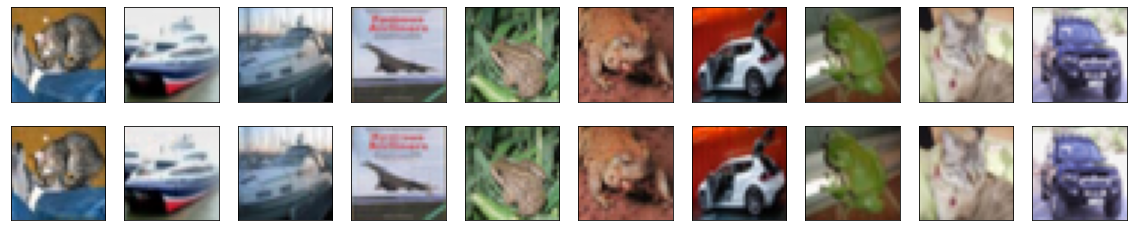

In [27]:
showOrigDec(input_test, denoised_images)

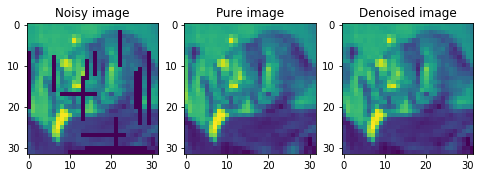

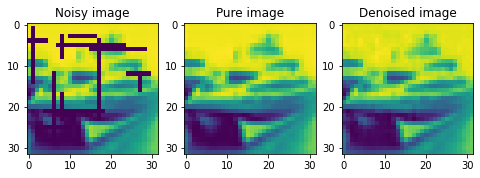

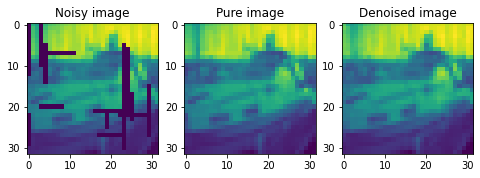

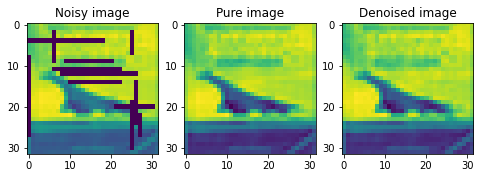

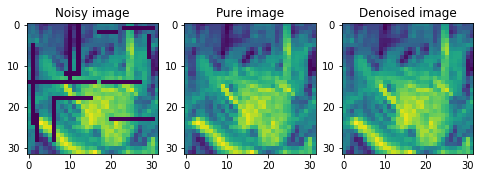

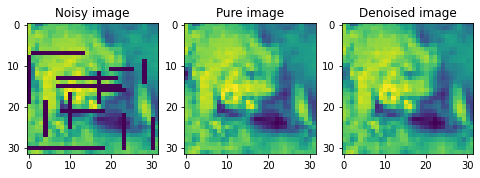

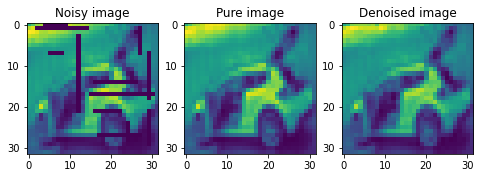

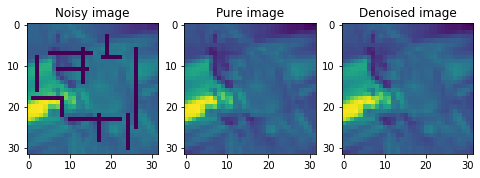

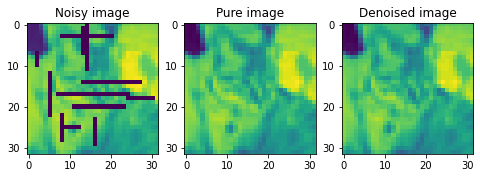

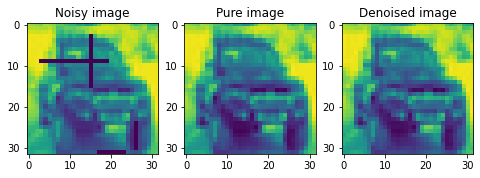

In [28]:
# Plot denoised images
for i in range(0, number_of_visualizations):
  # Get the sample and the reconstruction
  noisy_image = x_test_line[i][:, :, 0]
  pure_image  = input_test[i][:, :, 0]
  denoised_image = denoised_images[i][:, :, 0]
  input_class = targets[i]
  # Matplotlib preparations
  fig, axes = plt.subplots(1, 3)
  fig.set_size_inches(8, 3.5)
  # Plot sample and reconstruciton
  axes[0].imshow(noisy_image)
  axes[0].set_title('Noisy image')
  axes[1].imshow(pure_image)
  axes[1].set_title('Pure image')
  axes[2].imshow(denoised_image)
  axes[2].set_title('Denoised image')
  
  plt.show()